In [240]:
from nasbench201.search_model_darts_proj import TinyNetworkDartsProj
import torch
import torch.nn as nn
from nasbench201.cell_operations import SearchSpaceNames
import nasbench201.utils as ig_utils
import torch.utils
import torchvision.datasets as dset
import numpy as np
import copy

In [241]:
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)

In [242]:
class AGRS():
    def __init__(self):
        self.data = '../data'
        self.dataset = 'cifar10'
        self.train_portion = 0.5
        self.batch_size = 64
        self.init_channels=16
        self.layers = 8
        self.learning_rate = 0.025
        self.learning_rate_min = 0.001
        self.momentum = 0.9
        self.nesterov = False
        self.weight_decay = 3e-4
        self.grad_clip = 5
        self.cutout = False
args = AGRS()

In [243]:
def Jocab_Score(ori_model, input, target, weights=None):
    model = copy.deepcopy(ori_model)
    model.eval()
    model.proj_weights = weights
    num_edge, num_op = model.num_edge, model.num_op
    for i in range(num_edge):
        model.candidate_flags[i] = False
    batch_size = input.shape[0]
    model.K = torch.zeros(batch_size, batch_size).cuda()
    model.K_list = {}
    def counting_forward_hook(module, inp, out):
        if isinstance(inp, tuple):
            inp = inp[0]
        inp = inp.view(inp.size(0), -1)
        x = (inp > 0).float()
        K = x @ x.t()
        if x.cpu().numpy().sum() == 0:
            model.K = model.K
        else:
            K2 = (1.-x) @ (1.-x.t())
            model.K = model.K + K + K2
        model.K_list[module.name]=K
        #print(module)
        

    for name, module in model.named_modules():
        if isinstance(module, nn.ReLU):
            module.name = name
            module.register_forward_hook(counting_forward_hook)
    
    input = input.cuda()
    model(input)
    K = model.K.cpu().numpy()
    score = hooklogdet(model.K.cpu().numpy())
    #print(model.K_list)
    K_list = model.K_list
    del model
    del input
    return score, K,K_list

def hooklogdet(K, labels=None):
    s, ld = np.linalg.slogdet(K)
    return ld

In [244]:
train_transform, valid_transform = ig_utils._data_transforms_cifar10(args)
train_data = dset.CIFAR10(root=args.data, train=True, download=True, transform=train_transform)
valid_data = dset.CIFAR10(root=args.data, train=False, download=True, transform=valid_transform)

Files already downloaded and verified
Files already downloaded and verified


In [245]:
num_train = len(train_data)
indices = list(range(num_train))
split = 64

train_queue = torch.utils.data.DataLoader(
    train_data, batch_size=args.batch_size,
    sampler=torch.utils.data.sampler.SubsetRandomSampler(indices[:split]),
    pin_memory=True)
input, target = next(iter(train_queue))

In [1529]:
np.random.seed(2)
torch.manual_seed(2)
torch.cuda.manual_seed(2)
from scipy.stats import rankdata
input, target = next(iter(train_queue))
LAYER=8
OPN=4

In [1530]:
from nasbench201.cell_operations import OPS
class TinyNetwork(nn.Module):
    def __init__(self, C, N, num_classes, criterion, affine=False, track_running_stats=True, stem_channels=3):
        super(TinyNetwork, self).__init__()
        self.stem = nn.Sequential(
                nn.Conv2d(stem_channels, C, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(C))
        op_names=['skip_connect','nor_conv_1x1', 'nor_conv_3x3', 'avg_pool_3x3']
        self.N=N
        self.edges = nn.ModuleDict()
        for i in range(N):
            self.edges[str(i)]=nn.ModuleList([OPS[op_name](C, C, 1, affine, track_running_stats) for op_name in op_names])
        
        self.lastact    = nn.Sequential(nn.BatchNorm2d(C), nn.ReLU(inplace=True))
        self.global_pooling = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Linear(C, num_classes)
        self.cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        self.weights=[[1/4, 1/4, 1/4, 1/4],[1/4, 1/4, 1/4, 1/4],[1/4, 1/4, 1/4, 1/4],[1/4, 1/4, 1/4, 1/4],[1/4, 1/4, 1/4, 1/4],[1/4, 1/4, 1/4, 1/4],[1/4, 1/4, 1/4, 1/4],[1/4, 1/4, 1/4, 1/4]]
        self.weights = np.array(self.weights)
        self.weights=torch.from_numpy(self.weights)
    
    def forward(self, inputs):
        weights = self.weights
        sum_value=[]
        feature = self.stem(inputs)
        for i in range(self.N):
            feature=sum(op(feature, block_input=True)*w if w==0 else op(feature) * w for op, w in zip(self.edges[str(i)], weights[i]))
#             with torch.no_grad():
#                 print(self.calc_k(feature))
#                 print(torch.mean(torch.abs(feature)))
#                 print(torch.count_nonzero((feature>0).float()))
                
        out = self.lastact(feature)
        out = self.global_pooling( out )
        out = out.view(out.size(0), -1)
        logits = self.classifier(out)
        #print(sum_value)
        #print('model end')
        return logits
    
    def calc_k(self, inp):
        inp = inp.view(inp.size(0), -1)
        x = (inp > 0).float()
        K = x @ x.t()
        if x.cpu().numpy().sum() == 0:
            return 0
        else:
            K2 = (1.-x) @ (1.-x.t())
            K =  K + K2
            return hooklogdet(K.cpu().numpy())
        


In [1533]:
model = TinyNetwork(C=16, N=LAYER, num_classes=10, criterion=nn.CrossEntropyLoss())
#model.cuda()

In [1534]:
import torch.onnx 
model.eval()
  
torch.onnx.export(model,         # model being run 
     input,       # model input (or a tuple for multiple inputs) 
     "toy.onnx",       # where to save the model  
     export_params=False,  # store the trained parameter weights inside the model file 
     opset_version=10,    # the ONNX version to export the model to 
     do_constant_folding=True,  # whether to execute constant folding for optimization 
     input_names = ['modelInput'],   # the model's input names 
     output_names = ['modelOutput'], # the model's output names 
     dynamic_axes={'modelInput' : {1 : 'batch_size'},    # variable length axes 
                            'modelOutput' : {0 : 'batch_size'}}) 

/home/hongkaiw/anaconda2/envs/mct/lib/python3.7/site-packages/torch/tensor.py:593: RuntimeWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might lead to errors or silently give incorrect results).
  'incorrect results).', category=RuntimeWarning)
/home/hongkaiw/.local/lib/python3.7/site-packages/ipykernel_launcher.py:27: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!


In [1522]:
import torch.nn as nn
def Jocab_Score(ori_model, input, target, weights=None):
    model = copy.deepcopy(ori_model)
    model.eval()
    model.proj_weights = weights
    batch_size = input.shape[0]
    model.K = torch.zeros(batch_size, batch_size).cuda()
    model.K_list = {}
    model.count = 0
    def counting_forward_hook(module, inp, out):
        if isinstance(inp, tuple):
            inp = inp[0]
        inp = inp.view(inp.size(0), -1)
        #with torch.no_grad():
            #print(torch.sum((inp > 0).float()), torch.count_nonzero(inp))
        x = (inp > 0).float()
        K = x @ x.t()
        if x.cpu().numpy().sum() == 0:
            model.K = model.K
        else:
            K2 = (1.-x) @ (1.-x.t())
            model.K = model.K + K + K2
        model.K_list[module.name]=K
        #print(module)
        

    for name, module in model.named_modules():
        if isinstance(module, nn.ReLU):
        #if 'ReLU' in str(type(module)):
            module.name = name
            #print(module)
            model.count+=1
            module.register_forward_hook(counting_forward_hook)
    
    input = input.cuda()
    model(input, weights)
    K = model.K.cpu().numpy()
    score = hooklogdet(model.K.cpu().numpy())
    #print(model.K_list)
    K_list = model.K_list
    #print(model.count)
    del model
    del input
    return score, K,K_list

def hooklogdet(K, labels=None):
    s, ld = np.linalg.slogdet(K)
    return ld

In [1523]:
weights=[[1/4, 1/4, 1/4, 1/4],[1/4, 1/4, 1/4, 1/4],[1/4, 1/4, 1/4, 1/4],[1/4, 1/4, 1/4, 1/4],[1/4, 1/4, 1/4, 1/4],[1/4, 1/4, 1/4, 1/4],[1/4, 1/4, 1/4, 1/4],[1/4, 1/4, 1/4, 1/4]]


pt_score = []
avg_skip_rank=np.array([0.0,0.0,0.0,0.0])
count_skip = 0
crit,K,K_list = Jocab_Score(model, input,  target, weights)
for l in range(LAYER):
    op_s = []
    for o in range(OPN):
        w = copy.deepcopy(weights)
        w[l][o]=0
        crit,K,K_list = Jocab_Score(model, input,  target, w)
        pt_score.append(crit)
        op_s.append(crit)
    avg_skip_rank +=(rankdata(op_s))
    select=np.argmin(op_s)
    print(select)
    if select ==0:
        count_skip+=1
print(pt_score)
print(avg_skip_rank/LAYER)
print(count_skip)

2
0
1
1
1
1
1
2
[724.5167, 724.62964, 721.42676, 726.57513, 721.924, 724.0039, 724.2308, 724.328, 724.6446, 723.4378, 723.59174, 726.2936, 726.9928, 722.4523, 723.66644, 727.96545, 727.3341, 722.5211, 723.89703, 727.9818, 726.8876, 723.4647, 724.414, 727.43134, 727.0108, 724.00287, 724.3993, 727.34503, 727.5785, 724.18317, 724.01965, 727.66486]
[2.625 1.5   1.875 4.   ]
1


In [1467]:
disc_score = []
avg_skip_rank=np.array([0.0,0.0,0.0,0.0])
count_skip=0
for l in range(LAYER):
    op_s = []
    for o in range(OPN):
        w = copy.deepcopy(weights)
        w[l]=np.zeros_like(w[l])
        w[l][o]=1
        #w[l][0]=1
        crit,K,K_list = Jocab_Score(model, input,  target, w)
       #print(w)
        op_s.append(crit)
        disc_score.append(crit)
    #print([5-x for x in rankdata(op_s)])
    avg_skip_rank +=(5-rankdata(op_s))
    select=np.argmax(op_s)
    print(select)
    if select ==0:
        count_skip+=1
print(disc_score)
print(avg_skip_rank/LAYER)
print(count_skip)

2
[557.9228, 597.0493, 597.9796, 550.9689]
[3. 2. 1. 4.]
0


In [1468]:
w = copy.deepcopy(weights)
arch=[1,1,1,1,1,1,1,1]
for i in range(len(arch)):    
    w[i]=np.zeros_like(w[i])
    w[i][arch[i]]=1
crit,K,K_list = Jocab_Score(model, input,  target, w)


In [1469]:
from itertools import combinations_with_replacement,permutations,product
from tqdm.notebook import tqdm
final_score = []
archs=[]
archs =list(product([0,1,2,3], repeat=LAYER)) 
                 
archs = [list(x) for x in archs]
#print(archs)
for i in tqdm(range(len(archs))):
    arch = archs[i]
    w = copy.deepcopy(weights)
    for i in range(len(arch)):
        w[i]=np.zeros_like(w[i])
        w[i][arch[i]]=1
    crit,K,K_list = Jocab_Score(model, input,  target, w)
    final_score.append(crit)
print(final_score)

  0%|          | 0/4 [00:00<?, ?it/s]

[557.9228, 597.0493, 597.9796, 550.9689]


In [1470]:
import pandas as pd
df = pd.DataFrame(list(zip(archs, final_score)),columns =['arch', 'naswot'])
df

,arch,naswot
0,[0],557.922791
1,[1],597.049316
2,[2],597.979614
3,[3],550.968872


In [1471]:
index=0
best_nwot=[]
for l in range(LAYER):
    for o in range(OPN): 
        max_nwot=max(df[df.apply(lambda x: x['arch'][l]==o, axis=1)]['naswot'])
        best_nwot.append(max_nwot)
print(best_nwot)

[557.9227905273438, 597.04931640625, 597.9796142578125, 550.9688720703125]


In [1472]:
avg_rank=np.array([0.0,0.0,0.0,0.0])

for i in range(LAYER):
    #print(np.argmax(best_nwot[i*4:(i+1)*4]))
    avg_rank +=(5-rankdata(best_nwot[i*4:(i+1)*4]))
    #print((5-rankdata(best_nwot[i*4:(i+1)*4])))
print(avg_rank/LAYER)

2
[3. 2. 1. 4.]


In [1473]:
from scipy import stats
stats.spearmanr([x*-1 for x in pt_score], best_nwot)

SpearmanrResult(correlation=1.0, pvalue=0.0)

In [1474]:
print(disc_score)
stats.spearmanr(disc_score, best_nwot)

[557.9228, 597.0493, 597.9796, 550.9689]


SpearmanrResult(correlation=1.0, pvalue=0.0)

In [1485]:
cor_dic={}
cor_dic['zc_pt(nwot)']=[1.0,0.80,0.82,0.83,0.79,0.69,0.66,0.65]
cor_dic['disc_zc(nwot)']=[1.0,0.85,0.89,0.71,0.63,0.35,0.28,0.07]
#cor_dic['zc_pt(nwot)_w/o_skip']  =[1.0,0.5217,0.5533,0.6655,0.7019,0.5058,0.5801,0.637]
#cor_dic['disc_zc(nwot)_w/o_skip']=[1.0,0.4638,0.5788,0.7332,0.7419,0.5711,0.6141,0.6845]

In [1486]:
import matplotlib.pyplot as plt
import random
import statistics as stat
import itertools
marker = itertools.cycle(('^', 'x', 'o', 's', '*', '+', '1')) 
color = itertools.cycle(('b', 'c', 'r', 'g', 'y', 'm', 'k')) 

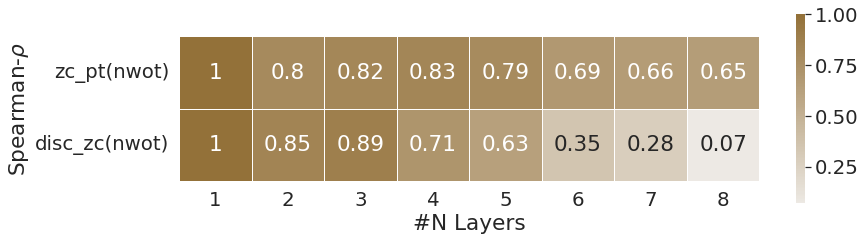

In [1488]:
import pathlib
import seaborn as sns
x = np.array([1, 2, 3, 4, 5, 6,7,8])
#plt.figure(figsize=(8.5,5.5))
idx=0
cor_df = pd.DataFrame.from_dict(cor_dic, orient='index')
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(13, 13))
sns.set(font_scale=1.8)
# Generate a custom diverging colormap
cmap = sns.diverging_palette(200, 55, as_cmap=True)
g = sns.heatmap(cor_df, cmap=cmap, center=0,
         square=True, linewidths=.5, cbar_kws={"shrink": .267}, annot=True,xticklabels=x)
plt.xlabel('#N Layers')
plt.ylabel('Spearman-$\\rho$')
#plt.xticks(x)
#plt.legend(bbox_to_anchor=(0.55, 0.65), prop={'size': 13})
#plt.grid()
plt.savefig(pathlib.Path('op_correl_layer_increase_toy').with_suffix('.pdf'), bbox_inches='tight')
plt.show()

In [999]:
rank_dic={}
rank_dic['zc_pt(nwot)']  =[4,4,4,4,2.6,2.67,2.71,2.75]
rank_dic['disc_zc(nwot)']=[4,4,4,2.5,2.2,2.33,2.28,2.25]

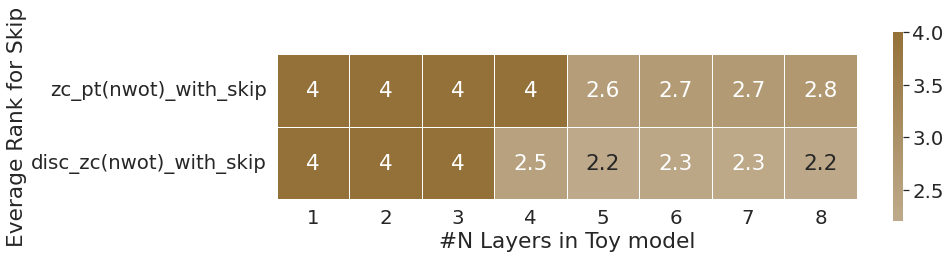

In [1087]:
import pathlib
x = np.array([1, 2, 3, 4, 5, 6,7,8])
idx=0
cor_df = pd.DataFrame.from_dict(rank_dic, orient='index')
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(13, 13))
#sns.set(font_scale=1.8)
# Generate a custom diverging colormap
cmap = sns.diverging_palette(200, 55, as_cmap=True)
g = sns.heatmap(cor_df, cmap=cmap, center=0,
         square=True, linewidths=.5, cbar_kws={"shrink": .267}, annot=True,xticklabels=x)
plt.xlabel('#N Layers in Toy model')
plt.ylabel('Everage Rank for Skip')
#plt.legend(bbox_to_anchor=(0.55, 0.65), prop={'size': 13})
#plt.grid()
plt.savefig(pathlib.Path('skip_layer_increase_toy').with_suffix('.pdf'), bbox_inches='tight')
plt.show()

In [1489]:
pt_dic={}
 #[3.         1.66666667 1.33333333 4.        ]             
pt_dic['skip']  =     [3,3.00,3.00,3.00,3.00,2.83,2.71,2.75]# 00000011
pt_dic['skip_select']=[0,0,0,0,0,0,1,1] 
pt_dic['conv_1x1']=   [2,1.50,1.67,1.75,1.60,1.83,1.71,1.75]#01112222
pt_dic['conv_1x1_select']=[0,1,1,1,2,2,2,2]
pt_dic['conv_3x3']=   [1,1.50,1.33,1.25,1.40,1.33,1.57,1.5]#21233445
pt_dic['conv_3x3_select']=[2,1,2,3,3,4,4,5]
pt_dic['avg_pooling']=[4,4.00,4.00,4.00,4.00,4.00,4.00,4.00]#00000000
pt_dic['avg_pooling_select']=[0,0,0,0,0,0,0,0]

In [1490]:
disc_dic={}
#[3.         1.33333333 1.66666667 4.        ]
disc_dic['skip']  =     [3,3.00,3.00,2.75,2.40,2.17,2.14,1.75]#00001225
disc_dic['skip_select']=[0,0,0,0,1,2,2,5] 
disc_dic['conv_1x1']=   [2,2.00,1.33,1.50,2.00,2.00,2.57,2.75]#00221321
disc_dic['conv_1x1_select']=[0,0,2,2,1,3,2,1]
disc_dic['conv_3x3']=   [1,1.00,1.67,1.75,1.80,2.17,2.00,2.25]#22123132
disc_dic['conv_3x3_select']=[2,2,1,2,3,1,3,2]
disc_dic['avg_pooling']=[4,4.00,4.00,4.00,3.80,3.67,3.29,3.25]#00000000
disc_dic['avg_pooling_select']=[0,0,0,0,0,0,0,0]

In [1491]:
best_dic={}

best_dic['skip']  =     [3,3.00,3.00,3.00,3.00,3.00,3.00,3.00]#00000000
best_dic['skip_select']=[0,0,0,0,0,0,0,0] 
best_dic['conv_1x1']=   [2,1.50,1.67,2.00,1.80,1.50,1.42,1.5]#01101344
best_dic['conv_1x1_select']=[0,1,1,0,1,3,4,4]
best_dic['conv_3x3']=   [1,1.50,1.33,1.00,1.20,1.50,1.57,1.5]#21244334
best_dic['conv_3x3_select']=[2,1,2,4,4,3,3,4]
best_dic['avg_pooling']=[4,4.00,4.00,4.00,4.00,4.00,4.00,4.00]#00000000
best_dic['avg_pooling_select']=[0,0,0,0,0,0,0,0]

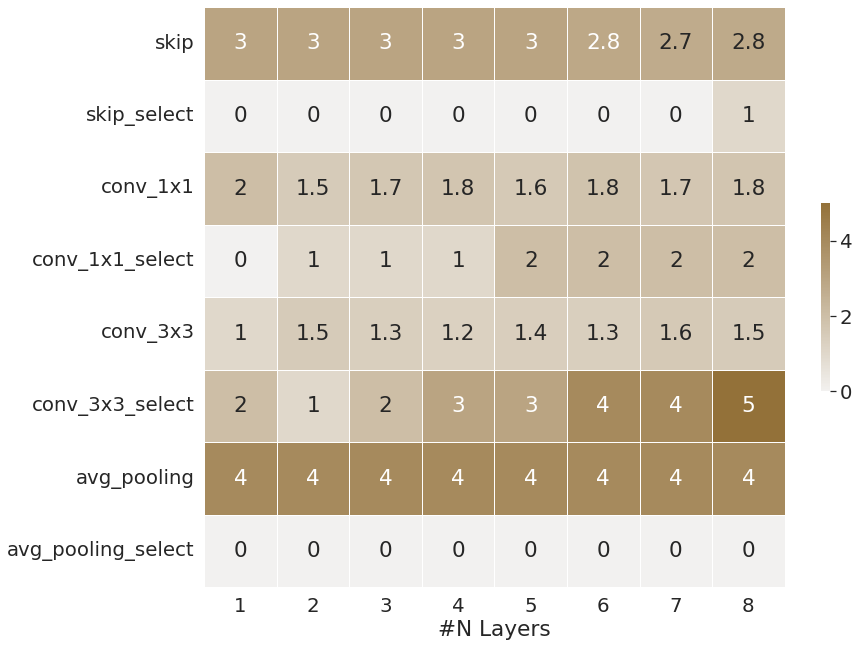

In [1496]:
import pathlib
x = np.array([1, 2, 3, 4, 5, 6,7,8])
idx=0
pt_df = pd.DataFrame.from_dict(pt_dic, orient='index')
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(13, 13))
#sns.set(font_scale=1.8)
# Generate a custom diverging colormap
cmap = sns.diverging_palette(200, 55, as_cmap=True)
g = sns.heatmap(pt_df, cmap=cmap, center=0,
         square=True, linewidths=.5, cbar_kws={"shrink": .267}, annot=True,xticklabels=x)
plt.xlabel('#N Layers')
plt.ylabel('')
#plt.legend(bbox_to_anchor=(0.55, 0.65), prop={'size': 13})
#plt.grid()
plt.savefig(pathlib.Path('op_select_pt').with_suffix('.pdf'), bbox_inches='tight')
plt.show()

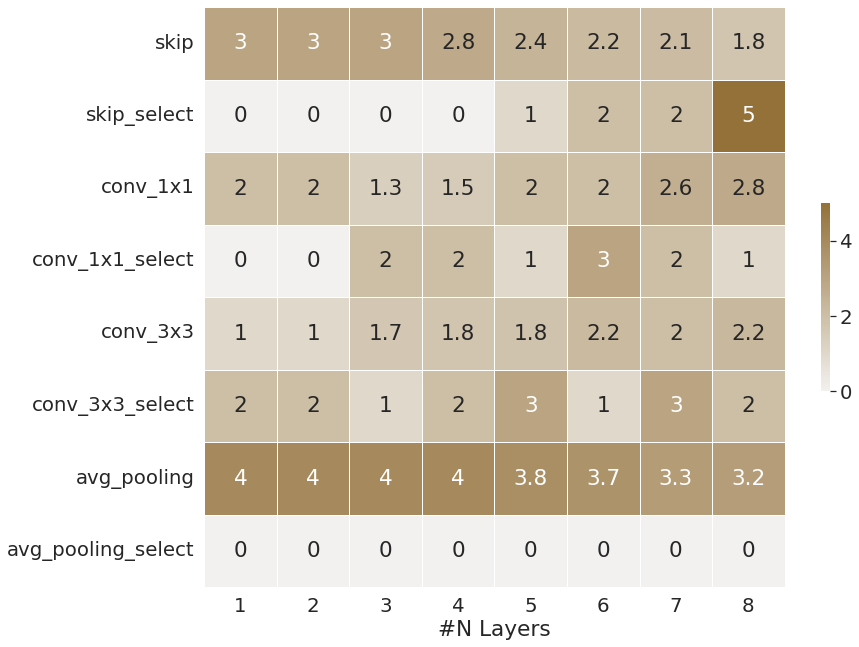

In [1497]:
import pathlib
x = np.array([1, 2, 3, 4, 5, 6,7,8])
idx=0
disc_df = pd.DataFrame.from_dict(disc_dic, orient='index')
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(13, 13))
#sns.set(font_scale=1.8)
# Generate a custom diverging colormap
cmap = sns.diverging_palette(200, 55, as_cmap=True)
g = sns.heatmap(disc_df, cmap=cmap, center=0,
         square=True, linewidths=.5, cbar_kws={"shrink": .267}, annot=True,xticklabels=x)
plt.xlabel('#N Layers')
plt.ylabel('')
#plt.legend(bbox_to_anchor=(0.55, 0.65), prop={'size': 13})
#plt.grid()
plt.savefig(pathlib.Path('op_select_disc').with_suffix('.pdf'), bbox_inches='tight')
plt.show()

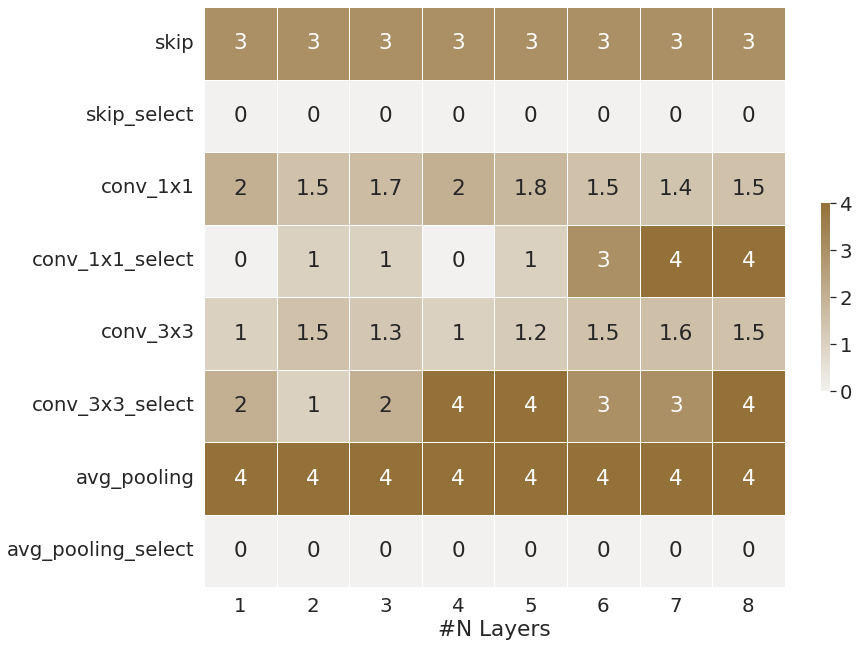

In [1498]:
import pathlib
x = np.array([1, 2, 3, 4, 5, 6,7,8])
idx=0
best_df = pd.DataFrame.from_dict(best_dic, orient='index')
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(13, 13))
#sns.set(font_scale=1.8)
# Generate a custom diverging colormap
cmap = sns.diverging_palette(200, 55, as_cmap=True)
g = sns.heatmap(best_df, cmap=cmap, center=0,
         square=True, linewidths=.5, cbar_kws={"shrink": .267}, annot=True,xticklabels=x)
plt.xlabel('#N Layers')
plt.ylabel('')
#plt.legend(bbox_to_anchor=(0.55, 0.65), prop={'size': 13})
#plt.grid()
plt.savefig(pathlib.Path('op_select_best').with_suffix('.pdf'), bbox_inches='tight')
plt.show()